# Getting Data

In [1]:
from setup_and_validation import download_data, validate_data
import polars as pl
import matplotlib.pyplot as plt

In [2]:
URL_DATA = 'https://storage.data.gov.my/healthcare/blood_donations_state.parquet'
df = download_data(URL_DATA)
df.head()


date,state,blood_type,donations
date,str,str,i64
2006-01-01,"""Johor""","""all""",87
2006-01-02,"""Johor""","""all""",15
2006-01-03,"""Johor""","""all""",8
2006-01-04,"""Johor""","""all""",33
2006-01-05,"""Johor""","""all""",20


In [3]:
validate_data(df)

All rows have been validated successfully.
No duplicated rows detected.


We have 458575 rows, let's check the contents.

In [4]:
print(f"Number of days: {df['date'].n_unique()}")
print(f"Number of blood types: {df['blood_type'].n_unique()}")
print(f"Number of states: {df['state'].n_unique()}")

Number of days: 7056
Number of blood types: 5
Number of states: 13


In [5]:
assert df.height == df['date'].n_unique() * df['blood_type'].n_unique() * df['state'].n_unique()

In [6]:
# Now, we could confirm that we have exactly one row per date / state / blood type combination.

In [7]:
## Numbers are reported per blood type and and combined, we can double check if the numbers match.

In [8]:
grouped_df = df.filter(pl.col('blood_type') != 'all').group_by(['state', 'date']).agg(pl.col('donations').sum())
df_all = df.filter(pl.col('blood_type') == 'all')
comp_df = df_all.join(grouped_df, on=['date', 'state'], how='inner').with_columns((pl.col('donations') - pl.col('donations_right')).alias('diff'))

In [9]:
diff_df = comp_df.filter(pl.col('diff') != 0)
diff_df

date,state,blood_type,donations,donations_right,diff
date,str,str,i64,i64,i64
2014-06-26,"""W.P. Kuala Lumpur""","""all""",641,639,2
2025-03-23,"""Selangor""","""all""",250,249,1
2023-09-13,"""W.P. Kuala Lumpur""","""all""",629,628,1
2011-08-07,"""W.P. Kuala Lumpur""","""all""",1002,1001,1
2012-05-09,"""Kelantan""","""all""",99,98,1
…,…,…,…,…,…
2021-06-25,"""W.P. Kuala Lumpur""","""all""",436,435,1
2025-01-14,"""W.P. Kuala Lumpur""","""all""",551,550,1
2019-07-06,"""W.P. Kuala Lumpur""","""all""",311,310,1


In [10]:
# We have 217 rows of mismatch, let's see how bad the mismtach is

In [11]:
print(diff_df['diff'].max())
print(diff_df['diff'].min())


3
1


In [12]:
# Differences seem not too bad, but let's check
diff_df.sort('diff', descending=True)

date,state,blood_type,donations,donations_right,diff
date,str,str,i64,i64,i64
2022-09-15,"""W.P. Kuala Lumpur""","""all""",577,574,3
2014-06-26,"""W.P. Kuala Lumpur""","""all""",641,639,2
2016-05-19,"""W.P. Kuala Lumpur""","""all""",290,288,2
2022-06-19,"""W.P. Kuala Lumpur""","""all""",939,937,2
2007-10-30,"""W.P. Kuala Lumpur""","""all""",445,443,2
…,…,…,…,…,…
2021-06-25,"""W.P. Kuala Lumpur""","""all""",436,435,1
2025-01-14,"""W.P. Kuala Lumpur""","""all""",551,550,1
2019-07-06,"""W.P. Kuala Lumpur""","""all""",311,310,1


In [13]:
# Seems to be a minor issue... 
# However, what we do is that we replace the 'all' count with our data. 
# Thus, going forward we will create a new column in the other dataset 

In [14]:
# We regroup this by pivoting the table
df = df.pivot(
    values="donations",
    index=["date", "state"],
    on="blood_type"
)
df

date,state,all,a,b,o,ab
date,str,i64,i64,i64,i64,i64
2006-01-01,"""Johor""",87,19,20,45,3
2006-01-02,"""Johor""",15,4,3,6,2
2006-01-03,"""Johor""",8,2,2,4,0
2006-01-04,"""Johor""",33,7,11,12,3
2006-01-05,"""Johor""",20,3,8,8,1
…,…,…,…,…,…,…
2025-04-22,"""W.P. Kuala Lumpur""",570,120,139,278,33
2025-04-23,"""W.P. Kuala Lumpur""",544,141,144,235,24
2025-04-24,"""W.P. Kuala Lumpur""",601,151,180,238,32


In [15]:
df = df.with_columns(pl.sum_horizontal(["a", "b", "o", "ab"]).alias("all"))
df

date,state,all,a,b,o,ab
date,str,i64,i64,i64,i64,i64
2006-01-01,"""Johor""",87,19,20,45,3
2006-01-02,"""Johor""",15,4,3,6,2
2006-01-03,"""Johor""",8,2,2,4,0
2006-01-04,"""Johor""",33,7,11,12,3
2006-01-05,"""Johor""",20,3,8,8,1
…,…,…,…,…,…,…
2025-04-22,"""W.P. Kuala Lumpur""",570,120,139,278,33
2025-04-23,"""W.P. Kuala Lumpur""",544,141,144,235,24
2025-04-24,"""W.P. Kuala Lumpur""",601,151,180,238,32


# Visualization

In [16]:
df_all = df.group_by(pl.col('date')).sum().drop('state').sort('date')
df_all

date,all,a,b,o,ab
date,i64,i64,i64,i64,i64
2006-01-01,525,152,139,194,40
2006-01-02,227,53,43,112,19
2006-01-03,112,29,21,56,6
2006-01-04,391,92,98,165,36
2006-01-05,582,149,198,193,42
…,…,…,…,…,…
2025-04-22,1449,351,346,667,85
2025-04-23,1778,438,491,733,116
2025-04-24,1425,357,392,600,76


In [17]:
# For visualization, we group this by week.
# Otherwise, the outcome plots cannot really show the line difference

In [18]:
df_weekly = (
    df_all
    .with_columns(
        [
            pl.col('date').dt.week().alias('week'),
            pl.col('date').dt.year().alias('year')
        ]
    ).group_by(['year', 'week']).sum()
    .sort('year', 'week')
    .drop('date')
    .with_columns(pl.concat_str(pl.col('year'), pl.col('week'), separator = '-')
    .alias('yearweek'))
)

df_weekly

year,week,all,a,b,o,ab,yearweek
i32,i8,i64,i64,i64,i64,i64,str
2006,1,2549,664,678,1013,194,"""2006-1"""
2006,2,2896,747,785,1181,183,"""2006-2"""
2006,3,5222,1322,1439,2138,323,"""2006-3"""
2006,4,3708,954,1038,1475,241,"""2006-4"""
2006,5,1766,416,481,751,118,"""2006-5"""
…,…,…,…,…,…,…,…
2025,13,7692,1887,2023,3386,396,"""2025-13"""
2025,14,8653,2130,2294,3729,500,"""2025-14"""
2025,15,12105,3021,3206,5140,738,"""2025-15"""


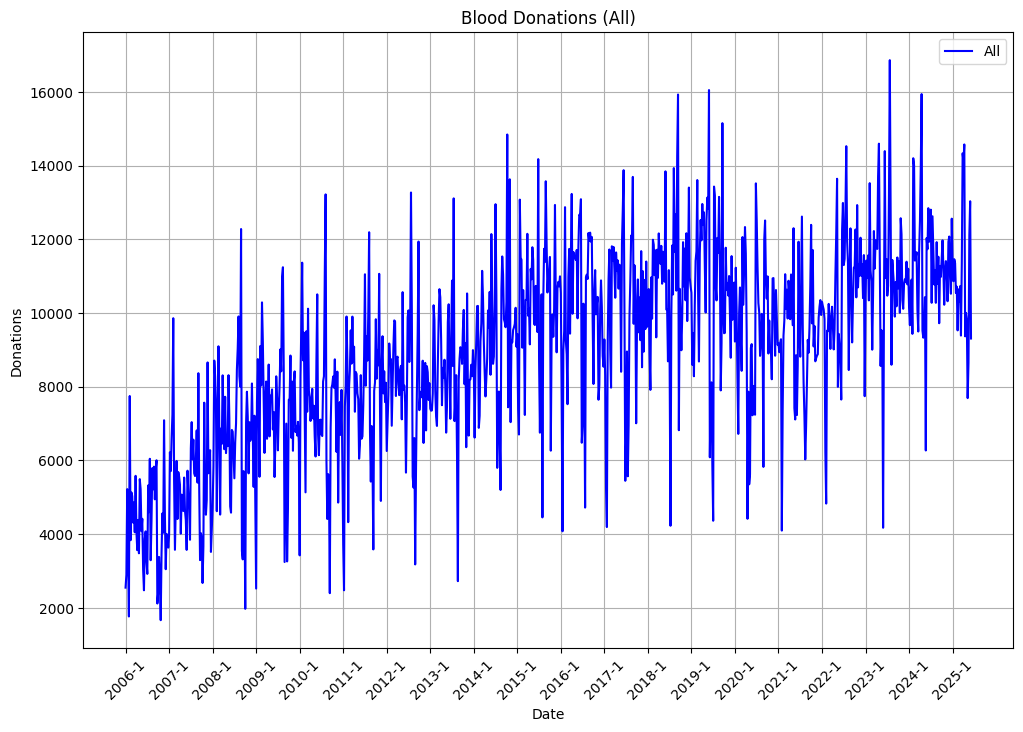

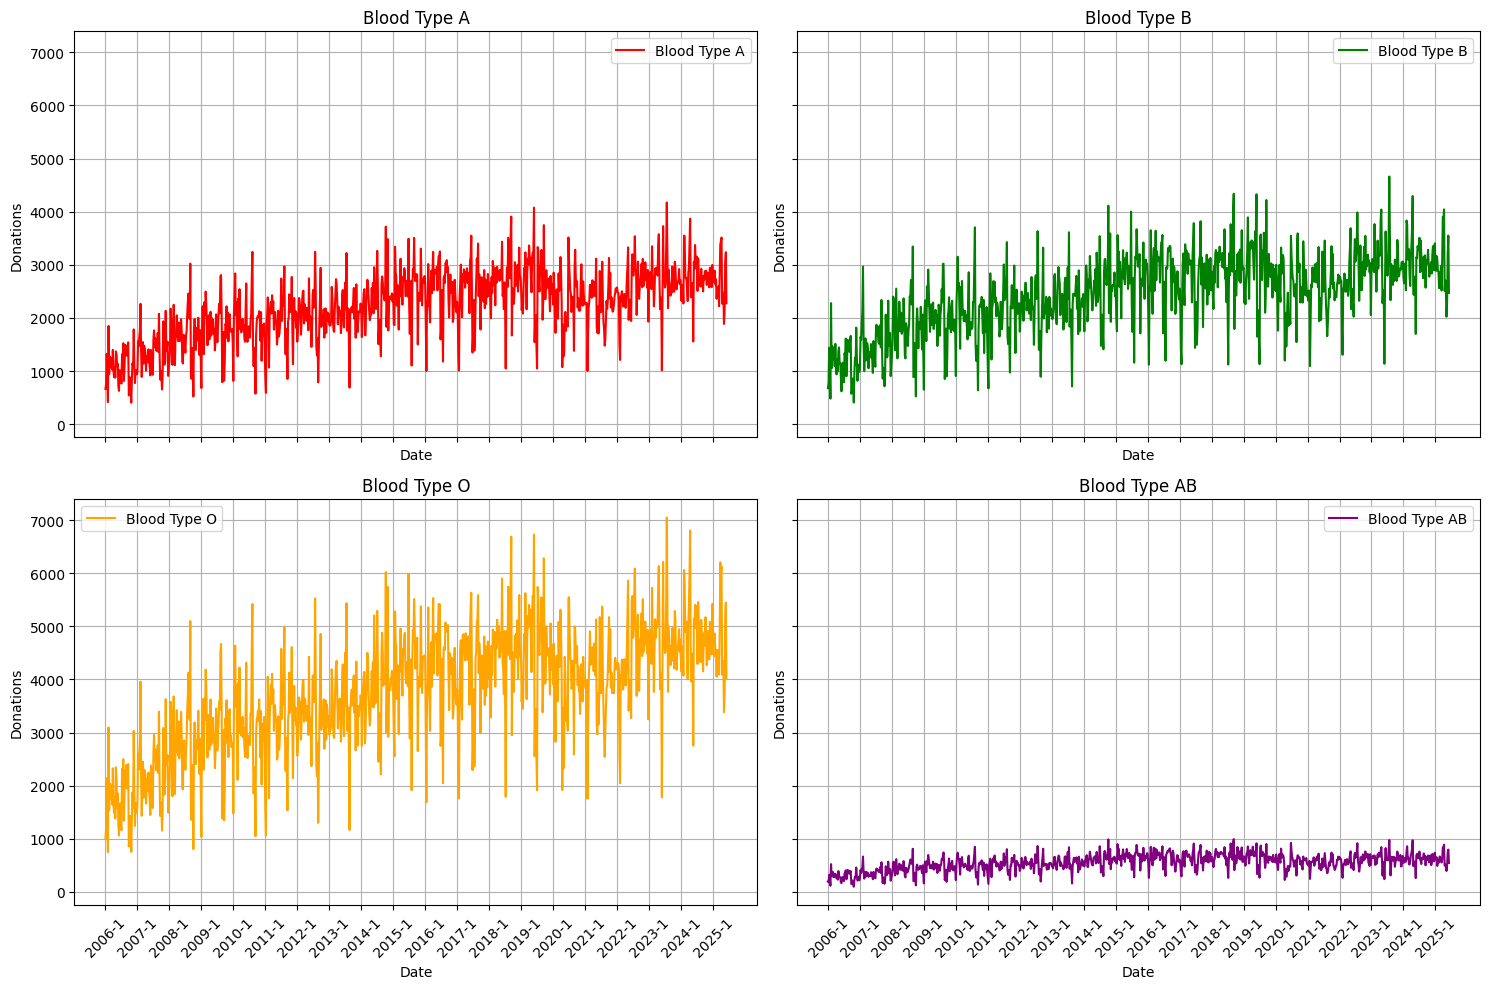

In [19]:
# Plot for the 'all' column
plt.figure(figsize=(12, 8))
plt.plot(df_weekly['yearweek'], df_weekly['all'], label='All', color='blue')
plt.title('Blood Donations (All)')
plt.xlabel('Date')
plt.ylabel('Donations')
plt.legend()
plt.grid()

# Set x-axis ticks to the first week of each year
year_ticks = df_weekly.filter(pl.col('week') == 1)['yearweek']
plt.xticks(ticks=range(0, len(df_weekly['yearweek']), 52),  # Approximate yearly interval
           labels=year_ticks, rotation=45)  # Rotate for readability

plt.show()

# 2x2 plot for 'a', 'b', 'o', and 'ab' columns
fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharex=True, sharey=True)

columns = ['a', 'b', 'o', 'ab']
titles = ['Blood Type A', 'Blood Type B', 'Blood Type O', 'Blood Type AB']
colors = ['red', 'green', 'orange', 'purple']

for i, ax in enumerate(axes.flat):
    ax.plot(df_weekly['yearweek'], df_weekly[columns[i]], label=titles[i], color=colors[i])
    ax.set_title(titles[i])
    ax.set_xlabel('Date')
    ax.set_ylabel('Donations')
    ax.legend()
    ax.grid()

    # Set x-axis ticks to the first week of each year
    ax.set_xticks(range(0, len(df_weekly['yearweek']), 52))  # Approximate yearly interval
    ax.set_xticklabels(year_ticks, rotation=45)  # Rotate for readability

plt.tight_layout()
plt.show()

In [ ]:
# What can we tell from here:
# - we see some seasonality/recurring patterns
# Blood Type O always had highest
# Blood type AB way lower than others
# We see a general increase overall

In [36]:
# Correlation matrices

for elem in df['state'].unique():
    print(elem)
    print(df.filter(df['state'] == elem).select(['a', 'b', 'o', 'ab']).corr())
    print("\n")

Selangor
shape: (4, 4)
┌──────────┬──────────┬──────────┬──────────┐
│ a        ┆ b        ┆ o        ┆ ab       │
│ ---      ┆ ---      ┆ ---      ┆ ---      │
│ f64      ┆ f64      ┆ f64      ┆ f64      │
╞══════════╪══════════╪══════════╪══════════╡
│ 1.0      ┆ 0.925244 ┆ 0.941213 ┆ 0.821189 │
│ 0.925244 ┆ 1.0      ┆ 0.9368   ┆ 0.823668 │
│ 0.941213 ┆ 0.9368   ┆ 1.0      ┆ 0.817098 │
│ 0.821189 ┆ 0.823668 ┆ 0.817098 ┆ 1.0      │
└──────────┴──────────┴──────────┴──────────┘


Pahang
shape: (4, 4)
┌──────────┬──────────┬──────────┬──────────┐
│ a        ┆ b        ┆ o        ┆ ab       │
│ ---      ┆ ---      ┆ ---      ┆ ---      │
│ f64      ┆ f64      ┆ f64      ┆ f64      │
╞══════════╪══════════╪══════════╪══════════╡
│ 1.0      ┆ 0.91823  ┆ 0.930743 ┆ 0.807814 │
│ 0.91823  ┆ 1.0      ┆ 0.935448 ┆ 0.817451 │
│ 0.930743 ┆ 0.935448 ┆ 1.0      ┆ 0.81732  │
│ 0.807814 ┆ 0.817451 ┆ 0.81732  ┆ 1.0      │
└──────────┴──────────┴──────────┴──────────┘


Terengganu
shape: (4, 4)
┌──────

In [37]:
df

date,state,all,a,b,o,ab
date,str,i64,i64,i64,i64,i64
2006-01-01,"""Johor""",87,19,20,45,3
2006-01-02,"""Johor""",15,4,3,6,2
2006-01-03,"""Johor""",8,2,2,4,0
2006-01-04,"""Johor""",33,7,11,12,3
2006-01-05,"""Johor""",20,3,8,8,1
…,…,…,…,…,…,…
2025-04-22,"""W.P. Kuala Lumpur""",570,120,139,278,33
2025-04-23,"""W.P. Kuala Lumpur""",544,141,144,235,24
2025-04-24,"""W.P. Kuala Lumpur""",601,151,180,238,32


In [ ]:
# Anomaly Detection
from scipy.stats import zscore

In [55]:
# Calculate Z-scores for all columns
z_scores_all = zscore(df_all['all'].to_numpy())
z_scores_a = zscore(df_all['a'].to_numpy())
z_scores_b = zscore(df_all['b'].to_numpy())
z_scores_ab = zscore(df_all['ab'].to_numpy())
z_scores_o = zscore(df_all['o'].to_numpy())

df_all = df_all.with_columns(
    pl.Series(name='z_scores_all', values=z_scores_all),
    pl.Series(name='z_scores_a', values=z_scores_a),
    pl.Series(name='z_scores_b', values=z_scores_b),
    pl.Series(name='z_scores_ab', values=z_scores_ab),
    pl.Series(name='z_scores_o', values=z_scores_o)
)

threshold = 2.56
anomalies_all = df_all.filter((pl.col('z_scores_all') > threshold) | (pl.col('z_scores_all') < -threshold))
anomalies_a = df_all.filter((pl.col('z_scores_a') > threshold) | (pl.col('z_scores_a') < -threshold))
anomalies_b = df_all.filter((pl.col('z_scores_b') > threshold) | (pl.col('z_scores_b') < -threshold))
anomalies_ab = df_all.filter((pl.col('z_scores_ab') > threshold) | (pl.col('z_scores_ab') < -threshold))
anomalies_o = df_all.filter((pl.col('z_scores_o') > threshold) | (pl.col('z_scores_o') < -threshold))

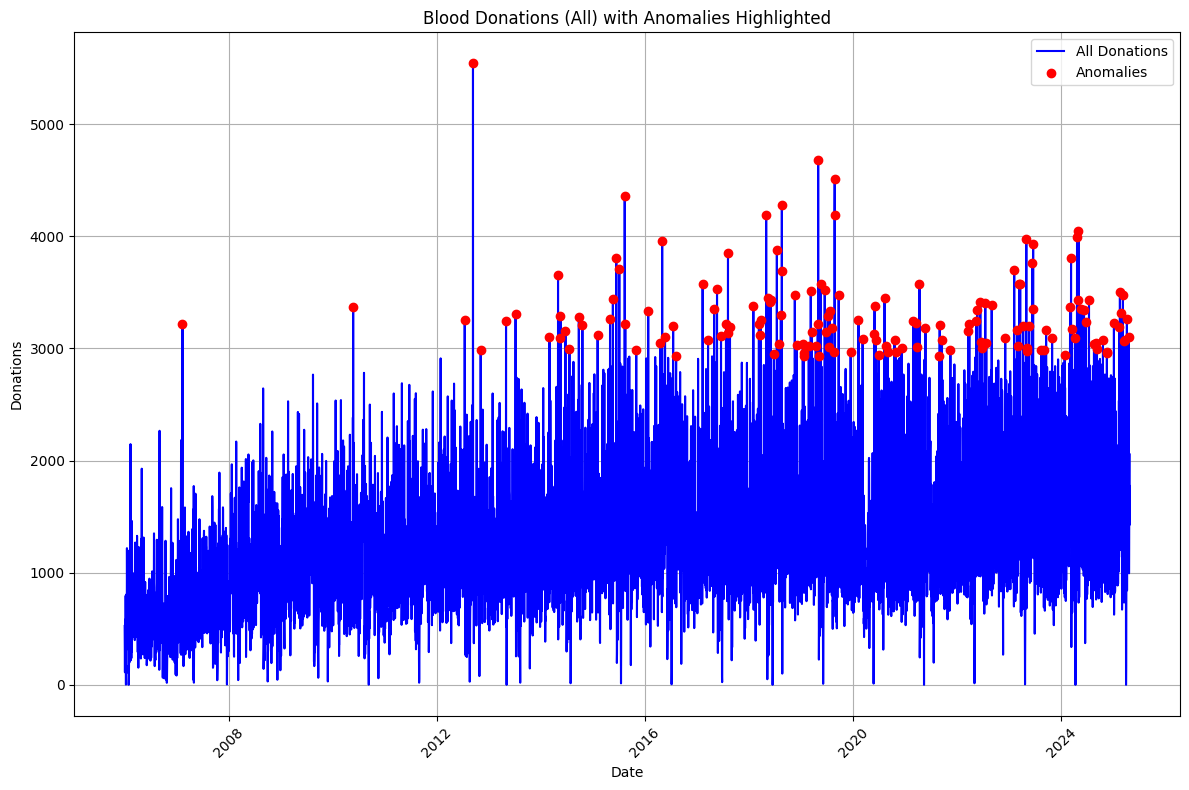

In [57]:
# Highlight anomalies on the 'all' column plot 
plt.figure(figsize=(12, 8))
plt.plot(df_all['date'], df_all['all'], label='All Donations', color='blue')
# Highlight anomalies on the 'all' column plot
plt.scatter(anomalies_all['date'], anomalies_all['all'], color='red', label='Anomalies', zorder=5)
plt.title('Blood Donations (All) with Anomalies Highlighted')
plt.xlabel('Date')
plt.ylabel('Donations')
plt.legend()
plt.grid()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

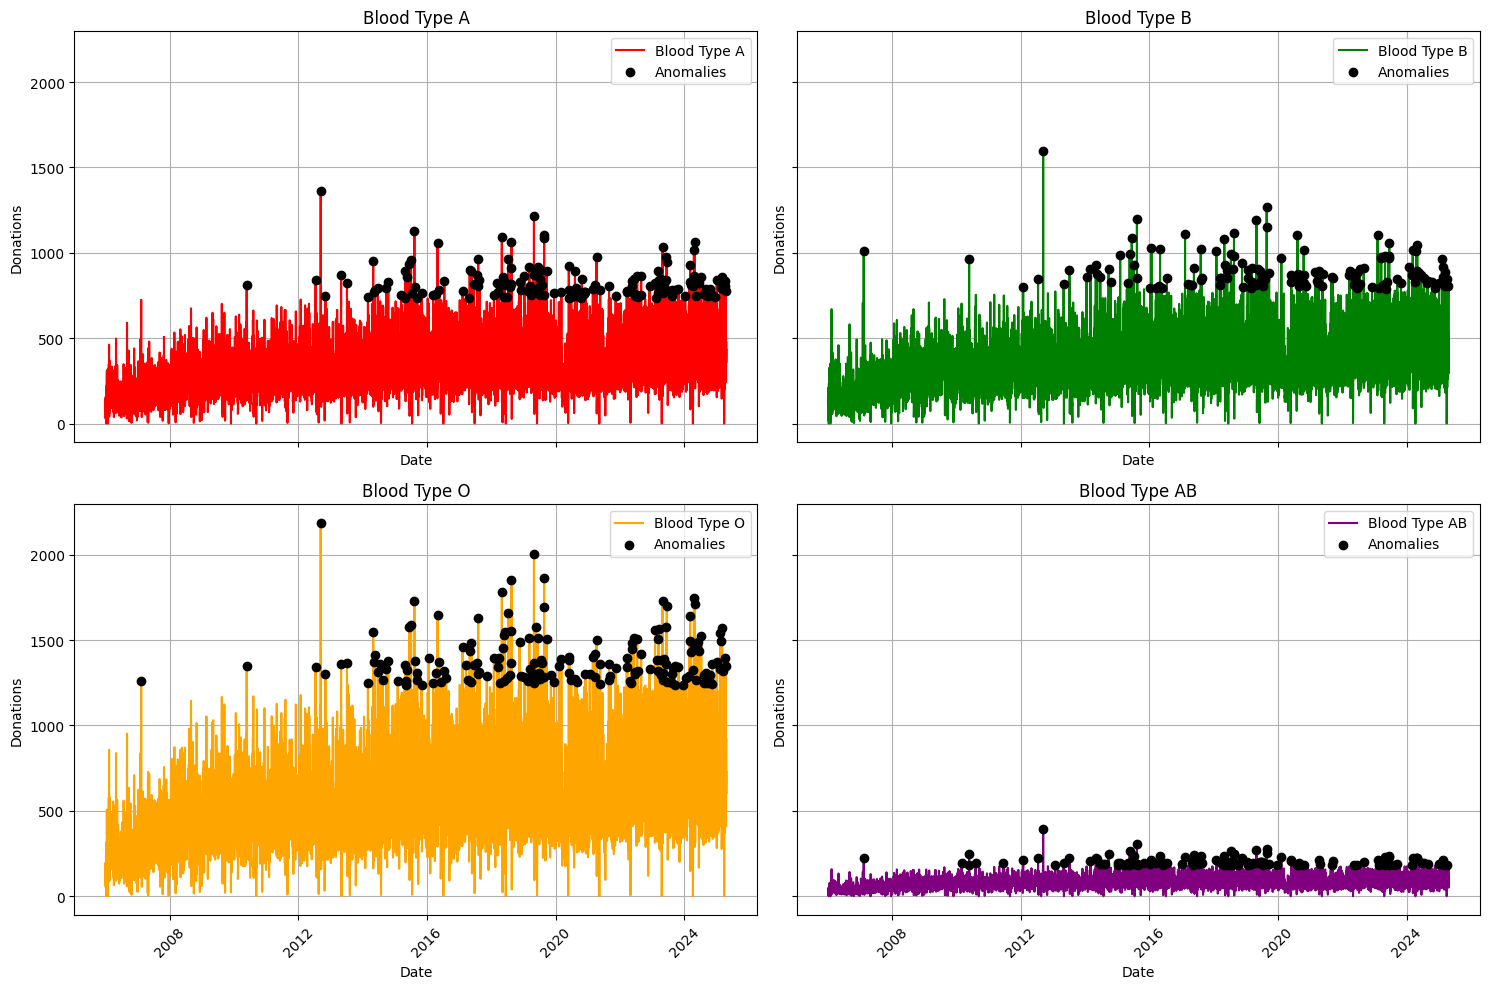

In [58]:
# 2x2 plot for 'a', 'b', 'o', and 'ab' columns with anomalies highlighted
fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharex=True, sharey=True)

columns = ['a', 'b', 'o', 'ab']
titles = ['Blood Type A', 'Blood Type B', 'Blood Type O', 'Blood Type AB']
colors = ['red', 'green', 'orange', 'purple']
anomalies = [anomalies_a, anomalies_b, anomalies_o, anomalies_ab]

for i, ax in enumerate(axes.flat):
    ax.plot(df_all['date'], df_all[columns[i]], label=titles[i], color=colors[i])
    ax.scatter(anomalies[i]['date'], anomalies[i][columns[i]], color='black', label='Anomalies', zorder=5)
    ax.set_title(titles[i])
    ax.set_xlabel('Date')
    ax.set_ylabel('Donations')
    ax.legend()
    ax.grid()

    # Rotate x-axis labels for better readability
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [47]:
# We see some anomalies, but all on the higher side